# Yelp Reviews - Restaurant Review Topic Analysis  
* Ankur Vishwakarma  
* Metis SF Winter 2018

## Notebook 2 - Text processing  
Previous notebook - [1_extracting_reviews](1_extracting_reviews)  

---

## Table of Contents  
1. [Stopwords](#s1)
2. [TFIDF](#s2)
3. [LSA](#s3)
4. [NMF](#s4)
5. [Review Similarity in NMF space](#s5)
6. [Count Vectorizer](#s6)
7. [LDA](#s7)
8. [Continuing with NMF Topics](#s8)
9. [Topic Modeling All Reviews](#s9)
10. [Adding Topic Weights to Pandas DataFrame](#s10)
11. [Adding in Business Information](#s11)

In [1]:
# import initial modules
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# read in reviews from previous notebook
data = pd.read_csv('review_steakhouse.csv')

In [3]:
data['review_length'] = data.text.map(len)

In [4]:
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
import sys
import time
import collections
from array import array

In [5]:
badreviews = data[(data.stars_x <= 2 )]
goodreviews = data[(data.stars_x >= 4)]
badreviews = badreviews.text
goodreviews = goodreviews.text
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  7,284


In [6]:
badreviews = ["".join([char for char in a if char not in string.punctuation]) for a in badreviews]
goodreviews = ["".join([char for char in a if char not in string.punctuation]) for a in goodreviews]

In [7]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [8]:
text1=badreviews
text1 = [a.lower() for a in text1]
words1 = [nltk.word_tokenize(a) for a in text1]
filtered_words1 = [[word for word in a if word not in stop_words] for a in words1]
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [9]:
text2=goodreviews
text2 = [a.lower() for a in text2]
words2 = [nltk.word_tokenize(a) for a in text2]
filtered_words2 = [[word for word in a if word not in stop_words] for a in words2]

In [10]:
lemmatized_words1 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words1]
lemmatized_words2 = [[lmtzr.lemmatize(x) for x in a] for a in filtered_words2]

In [11]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
lemmatized_words1=[ ' '.join(map(str, sent)) for sent in lemmatized_words1]
lemmatized_words2=[ ' '.join(map(str, sent)) for sent in lemmatized_words2]

In [12]:
tfidf_model1 = TfidfVectorizer(stop_words=stop_words,
                        ngram_range=(1,1))
tfidf_model2 = TfidfVectorizer(stop_words=stop_words, 
                        ngram_range=(1,1))
result1=tfidf_model1.fit_transform(lemmatized_words1)
result2=tfidf_model2.fit_transform(lemmatized_words2)

In [13]:
bad_df = pd.DataFrame(result1.todense(), columns=[tfidf_model1.get_feature_names()])
good_df = pd.DataFrame(result2.todense(), columns=[tfidf_model2.get_feature_names()])
col_means_bad = {}
for col in bad_df:
    col_means_bad[col] = bad_df[col].mean()

col_means_good = {}
for col in good_df:
    col_means_good[col] = good_df[col].mean()
    
top_words = 8

print('Top words in good reviews:')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:top_words])

print('Top words in bad reviews:')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:top_words])

Top words in good reviews:
[('great',), ('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('best',)]
Top words in bad reviews:
[('food',), ('steak',), ('service',), ('time',), ('place',), ('table',), ('restaurant',), ('ordered',)]


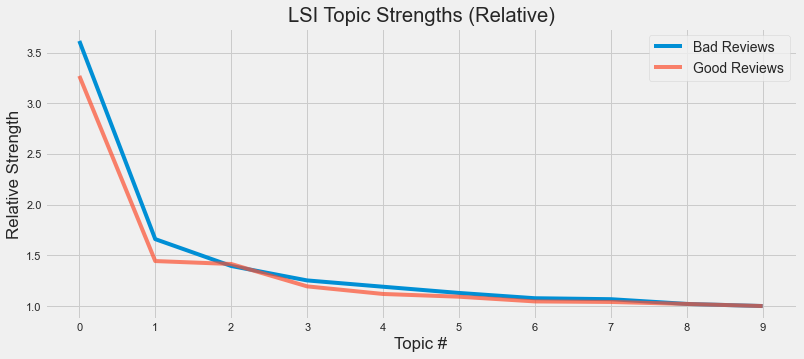

In [14]:
'This part credited to Ankur Vishwakarma, Oakland, CA. https://github.com/Vishwacorp/'
from gensim import corpora, models, similarities, matutils
corpus1 = matutils.Sparse2Corpus(result1.transpose())
corpus2 = matutils.Sparse2Corpus(result2.transpose())
word_bad = dict((v,k) for k,v in tfidf_model1.vocabulary_.items())
word_good = dict((v,k) for k,v in tfidf_model2.vocabulary_.items())
word_bad2 = corpora.Dictionary.from_corpus(corpus1, id2word=word_bad)
word_good2 = corpora.Dictionary.from_corpus(corpus2, id2word=word_good)
lsi_bad = models.LsiModel(corpus1, id2word=word_bad2, num_topics=10)
lsi_good = models.LsiModel(corpus2, id2word=word_good2, num_topics=10)

singular_values_bad = lsi_bad.projection.s.tolist()
singular_values_bad_rel = [sv/singular_values_bad[-1] for sv in singular_values_bad]
singular_values_good = lsi_good.projection.s.tolist()
singular_values_good_rel = [sv/singular_values_good[-1] for sv in singular_values_good]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_bad)), singular_values_bad_rel, label='Bad Reviews', alpha=1.0)
plt.plot(range(len(singular_values_good)), singular_values_good_rel, label='Good Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_bad)), range(len(singular_values_bad)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [15]:
import pprint
from pprint import pprint

In [18]:
no_top_words = 8

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_good, key=col_means_good.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_bad, key=col_means_bad.get, reverse=True)[:no_top_words])

Top 8 words in POSITIVE reviews:[('great',), ('food',), ('service',), ('place',), ('steak',), ('time',), ('restaurant',), ('best',)]
Top 8 words in NEGATIVE reviews:[('food',), ('steak',), ('service',), ('time',), ('place',), ('table',), ('restaurant',), ('ordered',)]


### NMF <a name='s4'></a>

In [24]:
%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(result2)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(result1)
H_neg = nmf_neg.components_

Wall time: 1.31 s


In [25]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 4

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.776*salad, 0.763*meat, 0.681*ordered, 0.653*delicious
Topic 1:   1.366*cheese, 1.219*curd, 1.139*burger, 0.945*old
Topic 2:   1.989*great, 1.499*food, 1.126*service, 0.696*atmosphere
Topic 3:   2.520*steak, 0.846*best, 0.699*cooked, 0.419*perfectly

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.156*minute, 1.115*table, 0.760*drink, 0.705*order
Topic 1:   1.996*steak, 0.794*medium, 0.603*rare, 0.433*cooked
Topic 2:   0.795*salad, 0.542*ordered, 0.513*chicken, 0.482*cheese
Topic 3:   1.591*food, 1.192*service, 1.029*place, 0.586*time


As expected, these topics are far more interpretable.  
* First two topics for positive reviews seem to be (1) salad and sides and (2) meals other than steak.
* First two topics for negative reviews seem to be (1) slow service and (2) temperature of steak (seems like thai food in this subset of data).

In [26]:
np.random.seed(38)
num_reviews = 20000
random_pos = np.random.choice(goodreviews, size=num_reviews)

In [27]:
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(badreviews, size=num_reviews)

### Review Similarity in NMF space <a name='s5'></a>

In [28]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])

1237
I wanted to thank the manager and staff for finding room for our party of 12 then 13 at the last minute on Saturday night The service was exceptional the food was delicious and the setting and ambiance are spectacular Thanks for a wonderful night


In [29]:
# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [30]:
# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 1.000
Ive lived in Madison my entire life so the fact that I had not been to this establishment before last night is shocking to me From the moment we made reservations to when we were walking out after dinner the staff was so incredibly friendly and attentive 

We started out at the bar  which is still the original bar from 1929 with some refurbishing where Al Capone and John Dillinger and some other gangsters used to hang out 

We had The Godfather martini vodka pineapple juice and the Tommy Gun bourbon cherry juice  I recommend both

We were seated upstairs for dinner Our waitress told us a wellrehearsed history on the Wonder Bar and added that it is now considered a certified haunted establishment This is a thumbs up in my book Our steaks were made perfectly the salads and sides were just as good Try the cheesy hash browns Oh And as an appetizer get the crab cakes 

The prices are decent for the amount and quality of 

NMF seems to be working well and making good topics for us. But just to give it a shot, let's use CountVectorizer (instead of TFIDF) and try topic modeling through LDA. While slower, its use of a dirichlet prior can often give good results.

### Count Vectorizer <a name='s6'></a>

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(badreviews, size=num_reviews)
cv_random_pos = np.random.choice(goodreviews, size=num_reviews)

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [32]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

### LDA <a name='s7'></a>

In [33]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=4, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=4, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 1min 47s


In [34]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.014*"place" + 0.013*"great" + 0.013*"food" + 0.012*"bar" + '
  '0.010*"service" + 0.009*"time" + 0.007*"nice"'),
 (1,
  '0.015*"cheese" + 0.010*"great" + 0.009*"food" + 0.008*"old" + '
  '0.008*"ordered" + 0.007*"place" + 0.006*"restaurant"'),
 (2,
  '0.016*"steak" + 0.009*"salad" + 0.009*"food" + 0.008*"great" + '
  '0.008*"service" + 0.008*"place" + 0.008*"meat"'),
 (3,
  '0.036*"great" + 0.031*"food" + 0.021*"service" + 0.012*"place" + '
  '0.011*"best" + 0.009*"excellent" + 0.008*"delicious"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.014*"service" + 0.011*"place" + 0.010*"bar" + 0.008*"great" + '
  '0.007*"time" + 0.007*"restaurant" + 0.007*"better"'),
 (1,
  '0.013*"table" + 0.010*"service" + 0.010*"time" + 0.010*"place" + '
  '0.009*"salad" + 0.008*"ordered" + 0.007*"order"'),
 (2,
  '0.011*"time" + 0.011*"service" + 0.010*"restaurant" + 0.0

In this case, it seems that our LDA topics are more blended together into each other than the ones generated by NMF. Let's move forward with NMF.

### Continuing with NMF Topics <a name='s8'></a>

In [35]:
%%time
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos,tfidf_model2.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   0.776*salad, 0.763*meat, 0.681*ordered, 0.653*delicious
Topic 1:   1.366*cheese, 1.219*curd, 1.139*burger, 0.945*old
Topic 2:   1.989*great, 1.499*food, 1.126*service, 0.696*atmosphere
Topic 3:   2.520*steak, 0.846*best, 0.699*cooked, 0.419*perfectly
Wall time: 23 ms


In [36]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #14832
-------------------------
We stayed at the adjoining hotel while vending at the annual winter beerfest  We stumbled upon the hotel by accident and couldnt have been happier with the stay and the majority of that comment is from this restaurant  Our first impression of this amazing place was the super sweet super amazing Nami  This young lady knows more about beer than the majority of people that were at the beerfest to say shes a connoisseur is selling her short  She was kind polite and professional while being super friendly and awesome the entire stay  The food was absolutely amazing  Everything was not only presented extremely well but was all hand crafted artisan deliciousness  Our group was a mix of vegetarian pescitarian and meat eaters  We all found amazing choices and everyone raved about every dish  The french fries have to be the best fries Ive ever tasted in my life  The fish and chips were to die for they even served it with an amazing malt vinegar th

In [37]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.156*minute, 1.115*table, 0.760*drink, 0.705*order
Topic 1:   1.996*steak, 0.794*medium, 0.603*rare, 0.433*cooked
Topic 2:   0.795*salad, 0.542*ordered, 0.513*chicken, 0.482*cheese
Topic 3:   1.591*food, 1.192*service, 1.029*place, 0.586*time


In [38]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #2516
-------------------------
The place is very clean and spacious I felt comfortable in the restaurant Service was excellent The portions are generous however the the food is not flavorful I had carne asada rice and bears I didnt feel like anything was seasoned and I did not find myself wanting to take another bite which is very usual for me and Mexican food 

The place is ok if youre very hungry and you like bland food Personally Id rather wait in line at Maize
-------------------------
Topic 1: 0.0976
Topic 3: 0.0312
Topic 0: 0.0183
Topic 2: 0.0091


### Topic Modeling All Reviews <a name='s9'></a>  
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [39]:
print('Postive Reviews:  {:,}'.format(len(goodreviews)))
print('Negative Reviews:  {:,}'.format(len(badreviews)))

Postive Reviews:  17,270
Negative Reviews:  7,284


In [40]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_model1 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_model2 = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get the vectors
neg_vectors = tfidf_model1.fit_transform(badreviews)
pos_vectors = tfidf_model2.fit_transform(goodreviews)

Wall time: 1.36 s


In [41]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 4

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

C:\Users\13754\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Wall time: 1.45 s


In [42]:
no_topics = num_topics
no_top_words = 5

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_model2.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_model1.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   0.766*bar, 0.666*salad, 0.644*ordered, 0.640*delicious, 0.640*meat
Topic 1:   2.106*great, 1.511*food, 1.171*service, 0.711*atmosphere, 0.650*place
Topic 2:   1.536*cheese, 1.316*curds, 1.046*old, 0.893*fashioned, 0.757*burger
Topic 3:   2.179*steak, 0.865*best, 0.835*cooked, 0.592*steaks, 0.510*perfectly

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   1.299*place, 1.170*service, 0.648*dont, 0.578*great, 0.506*better
Topic 1:   1.909*steak, 0.884*medium, 0.659*rare, 0.453*cooked, 0.437*ordered
Topic 2:   1.092*minutes, 0.901*table, 0.626*order, 0.555*waited, 0.548*took
Topic 3:   0.797*salad, 0.593*chicken, 0.580*ordered, 0.546*cheese, 0.392*fries


In [43]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Quality of vegetable salads and meat products', 1:'Atmosphere and service', 
              2:'Quality of other main courses', 3:'Quality of Steaks'}

neg_topics = {0:'Service quality', 1:'Cooking of steaks', 2:'Service--Waiting time', 
              3:'Quality of other sides and snacks'}

### Adding Topic Weights to Pandas DataFrame <a name='s10'></a>

In [44]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = data[['business_id', 'stars_x', 'text', 'review_length']][data.stars_x>3].reset_index()
df_neg = data[['business_id', 'stars_x', 'text', 'review_length']][data.stars_x<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

Our topic weights are not immediately relevant as absolute numbers. Let's take a look. 

In [45]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.01551396 0.01319791 0.01480702 0.        ]
Sum of weights:  0.04351888636249507


To a business owner, it does not make sense that that a review they received is 0.016 topic 0 and all their topics sum up to 0.043. Therefore, we can normalize the weights so they all add up to 1. 

In [46]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.35648791 0.30326845 0.34024364 0.        ]]
Sum of normalized weights:  1.0


In [47]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [48]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars_x,text,review_length,0,1,2,3
0,JhxI7oS_jsFnq34dDubugQ,2,Rocky River location. Out of four different en...,425,0.323147,0.220360,0.001469,0.455024
1,zLnmmB9jiKg-A2Lggs64-A,1,"Not worth the price. Service was OK... ""Poop e...",64,1.000000,0.000000,0.000000,0.000000
2,7ddnq3YQSKguGK15etqGLQ,2,We decided on short notice to try the new Ditk...,942,0.239486,0.480081,0.001110,0.279323
3,zLnmmB9jiKg-A2Lggs64-A,2,Came here for the ayce seafood buffet what a d...,442,0.329776,0.088952,0.000000,0.581272
4,lpxj6LFir23Ds6swW8a6fg,1,Tourist trap. Like a bad cafeteria on top of M...,60,0.979663,0.020337,0.000000,0.000000


Great - we have topic weights for each review in this dataframe. Next, we can group by the business_id and get mean topic weights per restaurant.

In [49]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars_x':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars_x':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean'}).reset_index()

In [50]:
df_pos_bsns.head(5)

,business_id,stars_x,text,review_length,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,4.400000,20,481.650000,0.455453,0.267870,0.090952,0.185724
1,-bHpvkmiFzm_swHLYsGiqw,4.659091,88,540.954545,0.405884,0.383983,0.071390,0.138743
2,0YA3RpY5KXcezPXcjdfOGQ,5.000000,1,491.000000,0.275592,0.272366,0.000000,0.452042
3,0gbi6kYiAOnFwfZ_2_dXSA,4.528090,89,574.000000,0.316093,0.315641,0.058682,0.309584
4,0grgvnq4GgoY-estWytUhg,4.475410,61,657.360656,0.489593,0.321819,0.098266,0.090322


In [51]:
df_neg_bsns.head()

,business_id,stars_x,text,review_length,0,1,2,3
0,-RQCdTsH5rkG702auLcEqA,1.400000,10,991.500000,0.321232,0.204246,0.147369,0.327153
1,-bHpvkmiFzm_swHLYsGiqw,1.520000,25,700.480000,0.511158,0.110051,0.152027,0.226764
2,0YA3RpY5KXcezPXcjdfOGQ,1.200000,5,446.800000,0.383100,0.396977,0.121657,0.098265
3,0gbi6kYiAOnFwfZ_2_dXSA,1.692308,13,965.615385,0.239982,0.264789,0.192736,0.302493
4,0grgvnq4GgoY-estWytUhg,1.586207,29,968.137931,0.389274,0.030535,0.174895,0.405296


### Adding in Business Information <a name='s11'></a>

In [53]:
# we can read in business info from a saved CSV file
# and add that to our last dataframe
steak_df = pd.read_csv('review_steakhouse.csv')
steak_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
steak_df.columns=['id',"stars_x","useful","text","name","address","city","state","postal_code","stars_y","attributes","categories"]
steak_df.head()

,id,stars_x,useful,text,name,address,city,state,postal_code,stars_y,attributes,categories
0,lpxj6LFir23Ds6swW8a6fg,4,0,Very fresh food and authentic Italian taste. T...,Grandview Saloon,1212 Grandview Ave,Pittsburgh,PA,15211,3.0,"{'Alcohol': ""u'full_bar'"", 'WiFi': ""'free'"", '...","Restaurants, Steakhouses, Seafood, American (T..."
1,d6VYQbeTZ_WdD8Uuhh35dg,5,0,This is my favorite happy hour place in all of...,Tempest Oyster Bar,120 E Wilson St,Madison,WI,53703,4.0,"{'RestaurantsTakeOut': 'False', 'WiFi': ""u'no'...","Steakhouses, Restaurants, Bars, Seafood, Night..."
2,szGbmw_vq3kVU4SfK1x6Sw,4,1,Ruth Chris Steakhouse is by far one of the bes...,Ruths Chris Steak House,6 PPG Pl,Pittsburgh,PA,15222,4.0,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Steakhouses"
3,eF2jf-E5ktRQIh_4_-Jxsg,4,1,My rating is purely on the food and not on the...,Cannon's Chop House,1900 Main St,Canonsburg,PA,15317,3.5,"{'Alcohol': ""u'full_bar'"", 'RestaurantsReserva...","Steakhouses, Restaurants, Cajun/Creole"
4,JhxI7oS_jsFnq34dDubugQ,2,1,Rocky River location. Out of four different en...,Ferris Steak House,8700 Detroit Ave,Cleveland,OH,44102,3.5,"{'RestaurantsReservations': 'True', 'Restauran...","Steakhouses, Restaurants"


In [73]:
steak_df[['id', 'name', 'city', 'stars_x']].head()

,id,name,city,stars_x
0,188,Grandview Saloon,Pittsburgh,4
1,219,Tempest Oyster Bar,Madison,5
2,262,Ruths Chris Steak House,Pittsburgh,4
3,273,Cannon's Chop House,Canonsburg,4
4,393,Ferris Steak House,Cleveland,2


In [67]:
test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()
test.head()

<ipython-input-67-a3f6ee3d699e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test=df_pos_bsns.groupby(by=['business_id'])[0,1,2,3].sum()


,0,1,2,3
business_id,,,,
-RQCdTsH5rkG702auLcEqA,0.455453,0.267870,0.090952,0.185724
-bHpvkmiFzm_swHLYsGiqw,0.405884,0.383983,0.071390,0.138743
0YA3RpY5KXcezPXcjdfOGQ,0.275592,0.272366,0.000000,0.452042
0gbi6kYiAOnFwfZ_2_dXSA,0.316093,0.315641,0.058682,0.309584
0grgvnq4GgoY-estWytUhg,0.489593,0.321819,0.098266,0.090322


In [61]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(steak_df[['id','name', 'city', 'stars_x']], left_on='business_id', 
                               right_on='id')[['business_id', 'name', 'city','stars_y', 0, 1, 2, 3]]

df_neg_tot = df_neg_bsns.merge(steak_df[[ 'id','name', 'city', 'stars_x']], left_on='business_id', 
                               right_on='id')[['business_id', 'name', 'city','stars_y', 0, 1, 2, 3]]

KeyError: "['stars_y'] not in index"

In [60]:
# peek into business/topic distributions
#df_pos_tot.head()
df_pos_tot.dim()

AttributeError: 'DataFrame' object has no attribute 'dim'

We can check topic distributions for a business and see how they make sense after all the reviews have been normalized and then averaged up to the business-level. Let's check `business_id 'uOPzOiwkS_6w4txA7fYfeA'`, which happens to be a popular chili spot in Ohio.

In [1051]:
scores = df_pos_bsns[df_pos_bsns.business_id == 'uOPzOiwkS_6w4txA7fYfeA'].iloc[:,-6:].values
print(oh_df[oh_df.id == 'uOPzOiwkS_6w4txA7fYfeA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

Skyline Chili - Positive Reviews
------------------------------------
Topic 0: beer/happy_hour    > 0.0767
Topic 1: food/pizza         > 0.0327
Topic 2: service/atmosphere > 0.0818
Topic 3: food/burger/fries  > 0.0891
Topic 4: friendly_staff     > 0.3543
Topic 5: food/chicken/salad > 0.3655


We now have 4 dataframes:  
1. **`df_pos_tot`: ** topic distribution of positive reviews with name, city, and stars for all restaurants
2. **`df_neg_tot`: ** topic distribution of negative reviews with name, city, and stars for all restaurants
3. **`df_pos`: ** topic distribution of all positive reviews with associated business_id
4. **`df_neg`: ** topic distribution of all negative reviews with associated business_id  

We can write them to CSV files and then use that information for visualizations in Tableau.

In [1068]:
%%time
# write to CSV
df_pos_tot.to_csv('CSVs/pos_bsns.csv')
df_neg_tot.to_csv('CSVs/neg_bsns.csv')
df_pos.to_csv('CSVs/pos_reviews.csv')
df_neg.to_csv('CSVs/neg_reviews.csv')

CPU times: user 1.82 s, sys: 84 ms, total: 1.9 s
Wall time: 1.9 s
